# Step 1. Build the model


## Step 1.1 Load the packages.

In [1]:
%load_ext autoreload
%autoreload 2
# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed. https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
import os
import glob
import joblib
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from tensorflow.keras import Sequential
from tensorflow.keras import layers

# extra functions
from utility import generate_dataset, mean_absolute_error, mean_absolute_percentage_error, plot_result, report_results


## Step 1.2 Prepare the data for training and validation

In [2]:
path = Path("../Data/raw/AEMO/train/")
all_files = glob.glob(os.path.join(path, "*.csv"))
df_csv = pd.concat((pd.read_csv(f) for f in all_files))
df_csv.describe(include = 'all')

,REGION,SETTLEMENTDATE,TOTALDEMAND,RRP,PERIODTYPE
count,35040,35040,35040.000000,35040.000000,35040
unique,1,35040,NaN,NaN,1
top,VIC1,2019/12/12 16:30:00,NaN,NaN,TRADE
freq,35040,1,NaN,NaN,35040
mean,NaN,NaN,4932.293311,99.910524,NaN
std,NaN,NaN,863.693202,317.976582,NaN
min,NaN,NaN,3058.200000,-554.620000,NaN
25%,NaN,NaN,4284.952500,64.650000,NaN
50%,NaN,NaN,4831.930000,85.910000,NaN
75%,NaN,NaN,5427.075000,107.270000,NaN


In [3]:
validation_ratio = 0.25
n_dim_in = 12
n_dim_out = 1
X_train, y_train, X_val, y_val, scaler_demand = generate_dataset(
    df_csv, n_dim_in, n_dim_out, validation_ratio)

In [4]:
print(f'Training samples: input {X_train.shape}, target {y_train.shape}')
print(f'Validation samples: input {X_val.shape}, target {y_val.shape}') 

Training samples: input (26271, 12), target (26271, 1)
Validation samples: input (8757, 12), target (8757, 1)


## Step 1.3 initialize a model (model structure and algorithm).

In [5]:
model = Sequential(name = 'MLP_Demand_Prediction_Model')
model.add(layers.Dense(100, input_shape = (n_dim_in,), activation='relu', name = 'Hidden_Layer'))
model.add(layers.Dense(n_dim_out, name ='Output_Layer'))
model.summary()

Model: "MLP_Demand_Prediction_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden_Layer (Dense)         (None, 100)               1300      
_________________________________________________________________
Output_Layer (Dense)         (None, 1)                 101       
Total params: 1,401
Trainable params: 1,401
Non-trainable params: 0
_________________________________________________________________


## Step 1.4 Build the model with validation.

In [6]:
model.compile(loss='mae', optimizer='Adam', metrics=['mae', 'mape', 'mse'])
 
print('# Fit model on training data with validtion on validation data')
history = model.fit(X_train, y_train,
                    batch_size=1024,
                    epochs=200,
                    # We pass some validation for
                    # monitoring validation loss and metrics
                    # at the end of each epoch
                    validation_data=(X_val, y_val),
                    verbose=0)
print('# Done')

# Fit model on training data with validtion on validation data
# Done


In [7]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'mae', 'mape', 'mse', 'val_loss', 'val_mae', 'val_mape', 'val_mse'])


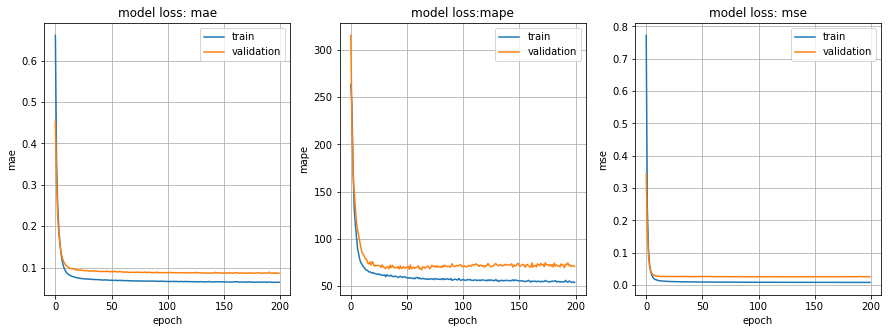

In [8]:
def plot_history(history):
    # summarize history for loss
    # Loss/MAE
    plt.figure(figsize=(15,5))
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss: mae')
    plt.ylabel('mae')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.grid(True)

    # MAPE
    plt.subplot(1, 3, 2)
    plt.plot(history.history['mape'])
    plt.plot(history.history['val_mape'])
    plt.title('model loss:mape')
    plt.ylabel('mape')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.grid(True)

    # MSE
    plt.subplot(1, 3, 3)
    plt.plot(history.history['mse'])
    plt.plot(history.history['val_mse'])
    plt.title('model loss: mse')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.grid(True)
    plt.show()
    
plot_history(history)

In [9]:
del model, history # delete the existing model

## Step 1.5 Build the model with Callback functions.

In [11]:
# Init a model
model = Sequential(name = 'MLP_Demand_Prediction_Model')
model.add(layers.Dense(100, input_shape = (n_dim_in,), activation='relu', name = 'Hidden_Layer'))
model.add(layers.Dense(n_dim_out, name ='Output_Layer'))
model.summary()

# Stop training when a monitored metric has stopped improving.
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# Callback to save the Keras model or model weights at some frequency.
checkpoint_filepath =  './models/checkpoints/weights.best.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True, 
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose = 0)

model.compile(loss='mae', optimizer='Adam', metrics=['mae', 'mape', 'mse'])
 
print('# Fit model on training data with validtion on validation data')
# Model (weights) are saved at the end of every epoch, if it's the best seen so far.
history = model.fit(X_train, y_train,
                    batch_size=1024,
                    epochs = 400,
                    # We pass some validation for
                    # monitoring validation loss and metrics
                    # at the end of each epoch
                    validation_data=(X_val, y_val),
                    verbose=0,
                    callbacks=[model_checkpoint_callback, earlystop_callback])

print('The model(that are considered the best) are loaded back into the model.')
model.load_weights(checkpoint_filepath)
print('# Done')

Model: "MLP_Demand_Prediction_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden_Layer (Dense)         (None, 100)               1300      
_________________________________________________________________
Output_Layer (Dense)         (None, 1)                 101       
Total params: 1,401
Trainable params: 1,401
Non-trainable params: 0
_________________________________________________________________
# Fit model on training data with validtion on validation data
The model(that are considered the best) are loaded back into the model.
# Done


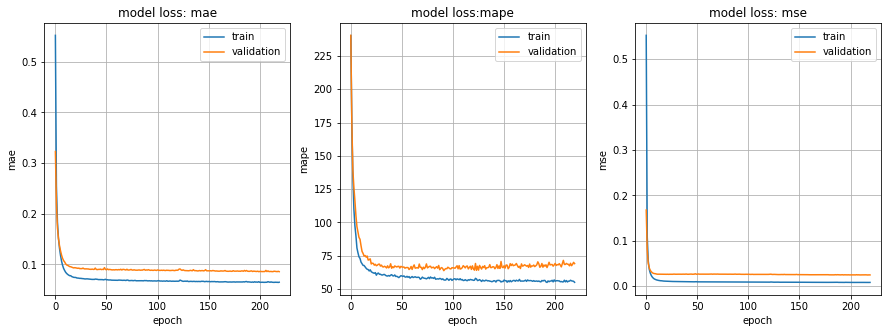

In [12]:
plot_history(history)

## Step 1.6 Check the training and validation errors with real values

### A. check the training results

In [13]:
print("# Training results:")
y_train_pred = model.predict(X_train) 
mae_train , mape_train = report_results(y_train, y_train_pred, scaler = scaler_demand)
print("[MAE ]: %.4f"     % mae_train)
print("[MAPE]: %.4f %% " % mape_train)

# Training results:
[MAE ]: 55.6156
[MAPE]: 1.1334 % 


In [14]:
print("# Validation results:")
y_val_pred = model.predict(X_val) 
mae_val, mape_val= report_results(y_val, y_val_pred, scaler = scaler_demand)
print("[MAE ]: %.4f"     % mae_val)
print("[MAPE]: %.4f %% " % mape_val)

# Validation results:
[MAE ]: 74.1140
[MAPE]: 1.5116 % 


In [15]:
from sklearn.metrics import mean_absolute_error
y_true = scaler_demand.inverse_transform(y_val)
y_pred  = scaler_demand.inverse_transform(y_val_pred)
print("# Validation results:")
print("[MAE ]: %.4f"     % mean_absolute_error(y_true, y_pred))  

# Validation results:
[MAE ]: 74.1140


## Step 1.7 Save the model and related scaler function.

In [16]:
# save our MLP model
filename = './models/MLP.demand.TF' + '.hdf5'
model.save(filename)

# save our scaler function 
filename = './models/scaler_demand.joblib' + '.z'
joblib.dump(scaler_demand, filename)

['./models/scaler_demand.joblib.z']

# End of Model Training